In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from model import *
from helpers import *
import torch
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import os 
import re
import glob

In [3]:
num = -3.0
mu = mu_p = num
width = 50
learning_rate = 1e-3
x_data,y_data,dataset_name = generate_5pt_dataset(plot = False)
beta_1, beta_2 = cal_betas(mu,mu_p, width)
print(beta_1, beta_2) # these are the std
savefolder = dataset_name
torch.backends.cudnn.deterministic = True
random_seed = 12
config = f"{mu:.3f}_{mu_p:.3f}_w{width}_rs{random_seed}"
operation_step_gap = 2000
loss_print_step = operation_step_gap
loss_update_step = operation_step_gap
weight_record_step = operation_step_gap 
output_plot_step = operation_step_gap
weight_savedir = "weight_recording"
error_savedir = "error_recording"
loss_savedir = "loss_recording"
parse_iter_id = -1
pic_savedir = 'pics'
training_iters = 6e5 

8e-06 8e-06


Training

In [4]:
net = two_layer_net(2,width,1,beta_1, beta_2, random_seed=random_seed,)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train(net, x_data, y_data, learning_rate, stopping_loss = 1e-5, max_iter = training_iters,
        config = config, weight_savedir=weight_savedir,
        loss_pic_savedir=pic_savedir, loss_print_step= loss_print_step, weight_record_step=weight_record_step, savefolder = savefolder,\
        loss_update_step=loss_update_step, loss_display_lim = 0.05)


-3.000_-3.000_w50_rs12
training


100%|██████████| 600000/600000.0 [00:42<00:00, 14113.72it/s]


<Figure size 600x400 with 0 Axes>

Reproducing Figure 3

In [5]:
weight_wholedir = os.path.join(savefolder, config, weight_savedir)
input_weights_paths = glob.glob(os.path.join(weight_wholedir,"*input.pt"))
output_weights_paths = glob.glob(os.path.join(weight_wholedir,"*output.pt"))
# order the sequence of the weight file path
def return_num_in_str(string, parse_num_id = parse_iter_id):
    return int(re.findall(r'\d+', string)[parse_num_id])
input_weights_paths = sorted(input_weights_paths, key = return_num_in_str)
output_weights_paths = sorted(output_weights_paths, key = return_num_in_str)
assert len(input_weights_paths)!=0
error_wholedir= os.path.join(savefolder, config, error_savedir)
errors_paths = glob.glob(os.path.join(error_wholedir,"*.pt"))
errors_paths = sorted(errors_paths, key = return_num_in_str)

# collecting all the data for the plots
all_steps_dataframe = pd.DataFrame()
for input_weights_path, output_weights_path, errors_path in tqdm(zip(input_weights_paths, output_weights_paths, errors_paths),total = len(input_weights_paths)):
    iter_num = re.findall(r'\d+', input_weights_path)[-1]
    input_weight = torch.load(input_weights_path,map_location = device)
    output_weight = torch.load(output_weights_path, map_location = device).reshape(-1,1)
    error = torch.load(errors_path, map_location = device)

    ## find out which open sectors actually have weights inside, and select out those d's corresponding to those sectors
    input_weight_zero_pos = (input_weight == torch.zeros(2)).any(axis = 1)
    output_weight_zero_pos = (output_weight == torch.zeros(1)).reshape(-1)
    overall_zero_pos = torch.logical_and(input_weight_zero_pos, output_weight_zero_pos) ## only weights with zero input and output weight at initialization time is guaranteed to have no effect on the system.
    nonzero_input_weight = input_weight[~overall_zero_pos]
    nonzero_output_weight = output_weight[~overall_zero_pos]
    nonzero_input_weight_ls = [tensor for tensor in nonzero_input_weight]
    nonzero_output_weight_ls = [tensor for tensor in nonzero_output_weight]
    nonzero_input_weight_id = (~overall_zero_pos).nonzero().squeeze(1)
    
    input_weight_norm = torch.linalg.norm(nonzero_input_weight, dim = 1) 
    input_weight_angle = np.arctan2(nonzero_input_weight[:,1], nonzero_input_weight[:,0])
    input_weight_angle = to_right_range(input_weight_angle)

    one_step_dataframe = pd.DataFrame(
        {   "iteration":[iter_num]*nonzero_input_weight_id.shape[0],
            "weight_id":nonzero_input_weight_id,
            "input_weight": nonzero_input_weight_ls,
            "output_weight": nonzero_output_weight_ls,
            "input_weight_angle": input_weight_angle,
            "input_weight_norm": input_weight_norm,
        }
    )

    all_steps_dataframe = pd.concat([all_steps_dataframe,one_step_dataframe],ignore_index=True)
    

all_steps_dataframe["weight_id"] = all_steps_dataframe["weight_id"].astype(str) ## better for visualization

critical_step_ls = np.array((42,152))*1000 # important steps to mark

all_steps_dataframe_new = all_steps_dataframe.copy() # back up the dataframe, just in case
all_steps_dataframe_new["iteration_num"] = all_steps_dataframe_new["iteration"].astype(int)

# figure out the color of the lines based on angles
angle_time_df = all_steps_dataframe_new.pivot(index="iteration_num",columns="weight_id",values="input_weight_angle")
iter_array = angle_time_df.index.values
# group the neurons based on their final angles
final_angle = angle_time_df.iloc[-1]
group1_condition = (final_angle>2) & (final_angle<3)
group1_id_ls = np.asarray(final_angle[group1_condition].index,dtype = 'int')
group2_condition = (final_angle>0) & (final_angle<1)
group2_id_ls = np.asarray(final_angle[group2_condition].index,dtype = 'int')
group3_condition = (final_angle>5.7) 
group3_id_ls = np.asarray(final_angle[group3_condition].index,dtype = 'int')
group4_condition = (final_angle>3.6) & (final_angle<3.7)
group4_id_ls = np.asarray(final_angle[group4_condition].index,dtype = 'int')
dead_group_condition = (~group1_condition)&(~ group2_condition)&(~ group3_condition)&(~ group4_condition)
dead_group_id_ls = np.asarray(final_angle[dead_group_condition].index,dtype = 'int')
# set the colors for different groups
def get_color(id):
    if id in group1_id_ls: return 'r'
    if id in group2_id_ls: return 'y'
    if id in group3_id_ls: return 'g'
    if id in group4_id_ls: return 'b'
    if id in dead_group_id_ls: return 'k'


100%|██████████| 300/300 [00:00<00:00, 1324.56it/s]


/var/folders/zg/kfrr72xj5k17btsxc3991cgr0000gn/T/ipykernel_13724/1583844955.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_yticklabels(axs[2].get_yticks(),  )
/var/folders/zg/kfrr72xj5k17btsxc3991cgr0000gn/T/ipykernel_13724/1583844955.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_yticklabels(axs[2].get_yticks(),  )


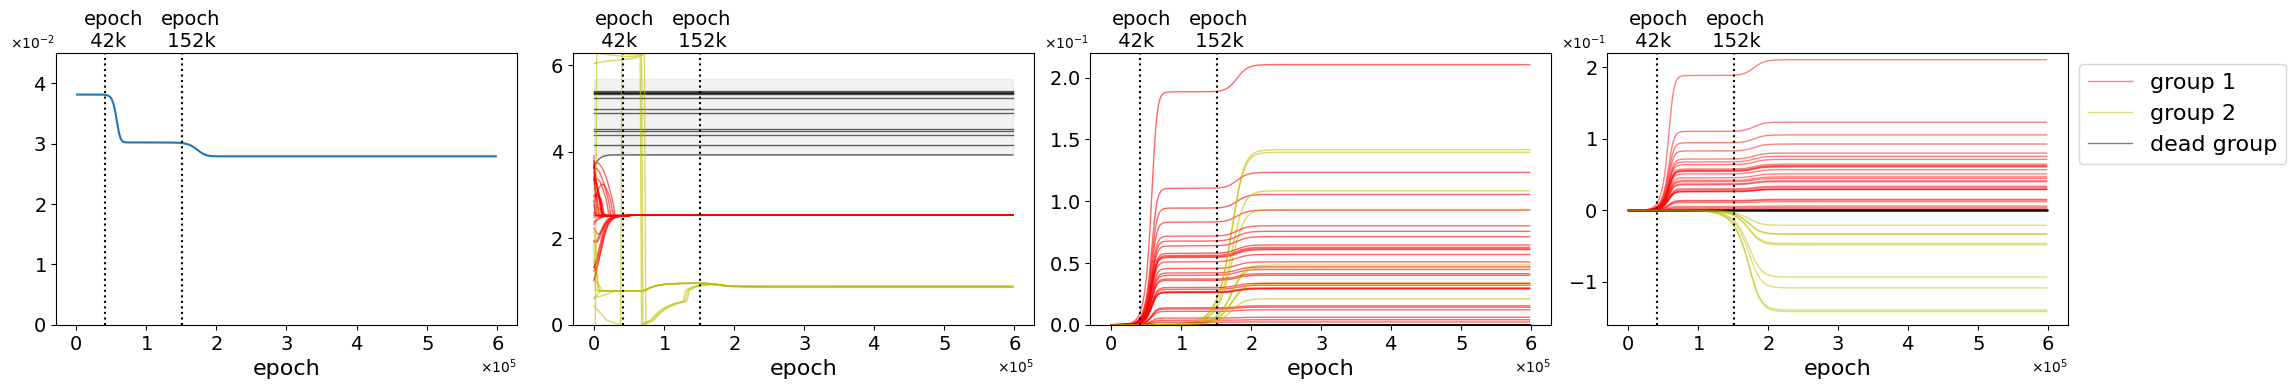

In [6]:
# Create a figure with 4 subplots in a row
fig, axs = plt.subplots(1, 4, figsize=(23, 4))  # 1 row, 4 columns
labelsize = 16
textsize = 14
ticksize = 14

# The loss plot
loss_dir = os.path.join(savefolder, config, loss_savedir, "loss.npz")
data = np.load(loss_dir)
loss_arr = data['loss_arr']
iter_arr = data['iter_arr']
axs[0].plot(iter_arr[1:], loss_arr[1:])
ylim_max = 0.045
axs[0].set_ylim([0,ylim_max])
for xc in critical_step_ls:
    axs[0].axvline(x=xc, color='k', linestyle=':')
    axs[0].text(xc-30000,ylim_max/44*45,f"epoch\n {int(xc/1000)}k",size=textsize)
axs[0].set_ylim([0, ylim_max])
axs[0].set_xlabel("epoch", fontsize=labelsize)
axs[0].xaxis.set_major_formatter(formatter1)
axs[0].set_yticklabels(axs[2].get_yticks(),  ) 
axs[0].yaxis.set_major_formatter(formatter)
axs[0].yaxis.get_offset_text().set_x(-0.1)
axs[0].tick_params(axis='both', which='major', labelsize=ticksize)


# Plot data on each subplot
group1_already = False
group2_already = False
group3_already = False
group4_already = False
dead_group_already = False
line_style = "-"
alpha = 0.6
linewidth = 1
for i in range(50):
    plot_data = angle_time_df[str(i)].values
    color = get_color(i)
    if color == 'r' and not group1_already:
        axs[1].plot(iter_array,plot_data, color+line_style, linewidth = linewidth, alpha = alpha, label = "group 1")
        group1_already = True
    elif color == 'y' and not group2_already:
        axs[1].plot(iter_array,plot_data, color+line_style, linewidth = linewidth, alpha = alpha,label = "group 2")
        group2_already = True
    elif color == 'g' and not group3_already:
        axs[1].plot(iter_array,plot_data, color+line_style, linewidth = linewidth, alpha = alpha,label = "group 3")
        group3_already = True
    elif color == 'b' and not group4_already:
        axs[1].plot(iter_array,plot_data, color+line_style, linewidth = linewidth, alpha = alpha,label = "group 4")
        group4_already = True
    elif color == 'k' and not dead_group_already:
        axs[1].plot(iter_array,plot_data, color+line_style, linewidth = linewidth, alpha = alpha,label = "dead group")
        dead_group_already = True
    else:
        axs[1].plot(iter_array,plot_data, color+line_style, linewidth = linewidth, alpha = alpha,)
axs[1].set_xlabel('epoch', fontsize = labelsize)
axs[1].fill_between(iter_array, 3.9269909858703613, 5.672459125518799, color = "gray", alpha = 0.1)
axs[1].xaxis.set_major_formatter(formatter1)
ylim_max = 2*np.pi
axs[1].set_ylim([0,ylim_max])
for xc in critical_step_ls:
    axs[1].axvline(x=xc, color='k', linestyle=':')
    axs[1].text(xc-40000,ylim_max/44*45,f"epoch\n {int(xc/1000)}k", size=textsize)
axs[1].tick_params(axis='both', which='major', labelsize=ticksize)

# input norm plot
input_norm_time_df = all_steps_dataframe_new.pivot(index="iteration_num", columns="weight_id", values="input_weight_norm")

group1_already = False
group2_already = False
group3_already = False
group4_already = False
dead_group_already = False
line_style = "-"
alpha = 0.6
linewidth = 1
for i in range(50):
    plot_data = input_norm_time_df[str(i)].values
    color = get_color(i)
    if color == 'r' and not group1_already:
        axs[2].plot(iter_array,plot_data, color+line_style, linewidth = linewidth, alpha = alpha, label = "group 1")
        group1_already = True
    elif color == 'y' and not group2_already:
        axs[2].plot(iter_array,plot_data, color+line_style, linewidth = linewidth, alpha = alpha,label = "group 2")
        group2_already = True
    elif color == 'k' and not dead_group_already:
        axs[2].plot(iter_array,plot_data, color+line_style, linewidth = linewidth, alpha = alpha,label = "dead group")
        dead_group_already = True
    else:
        axs[2].plot(iter_array,plot_data, color+line_style, linewidth = linewidth, alpha = alpha,)
axs[2].set_xlabel('epoch',fontsize = labelsize)
axs[2].xaxis.set_major_formatter(formatter1)
axs[2].set_yticklabels(axs[2].get_yticks(),  ) 
axs[2].yaxis.set_major_formatter(formatter)
axs[2].yaxis.get_offset_text().set_x(-0.1)
ylim_max = 0.22
axs[2].set_ylim([0,ylim_max])
for xc in critical_step_ls:
    axs[2].axvline(x=xc, color='k', linestyle=':')
    axs[2].text(xc-40000,ylim_max/44*45,f"epoch\n {int(xc/1000)}k", size=textsize)
axs[2].tick_params(axis='both', which='major', labelsize=ticksize)

# output weight plot
output_weight_time_df = all_steps_dataframe_new.pivot(index="iteration_num", columns="weight_id", values="output_weight")
group1_already = False
group2_already = False
group3_already = False
group4_already = False
dead_group_already = False
line_style = "-"
alpha = 0.5
linewidth = 1
for i in range(50):
    plot_data = output_weight_time_df[str(i)].values
    color = get_color(i)
    if color == 'r' and not group1_already:
        axs[3].plot(iter_array,plot_data, color+line_style, linewidth = linewidth, alpha = alpha, label = "group 1")
        group1_already = True
    elif color == 'y' and not group2_already:
        axs[3].plot(iter_array,plot_data, color+line_style, linewidth = linewidth, alpha = alpha,label = "group 2")
        group2_already = True
    elif color == 'k' and not dead_group_already:
        axs[3].plot(iter_array,plot_data, color+line_style, linewidth = linewidth, alpha = alpha,label = "dead group")
        dead_group_already = True
    else:
        axs[3].plot(iter_array,plot_data, color+line_style, linewidth = linewidth, alpha = alpha,)
axs[3].set_xlabel('epoch', fontsize = labelsize)
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,2,1]
axs[3].xaxis.set_major_formatter(formatter1)
axs[3].yaxis.set_major_formatter(formatter)
axs[3].legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=labelsize, bbox_to_anchor=(1., 1))
axs[3].yaxis.get_offset_text().set_x(-0.1)
# do the vertical line
ylim_min = -0.16
ylim_max = 0.22
axs[3].set_ylim([ylim_min, ylim_max])
for xc in critical_step_ls:
    axs[3].axvline(x=xc, color='k', linestyle=':')
    axs[3].text(xc-40000,ylim_min+(ylim_max-ylim_min)/44*45,f"epoch\n {int(xc/1000)}k", size=textsize)
axs[3].tick_params(axis='both', which='major', labelsize=ticksize)


plt.subplots_adjust(wspace=0.15)
plt.tight_layout()
plt.savefig(os.path.join(savefolder,config, "all_in_one_plot.png"),dpi=300)


Numerically verifying the local minimality of the last stationarity point

In [7]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)


loss = 0.027885962277650833
perturbing
perturb_amplitude: 0.0001283055025851354
perturb amplitude:  0.0001283055025851354


100%|██████████| 5000/5000 [00:04<00:00, 1082.29it/s]


min loss change: 3.4086406230926514e-06


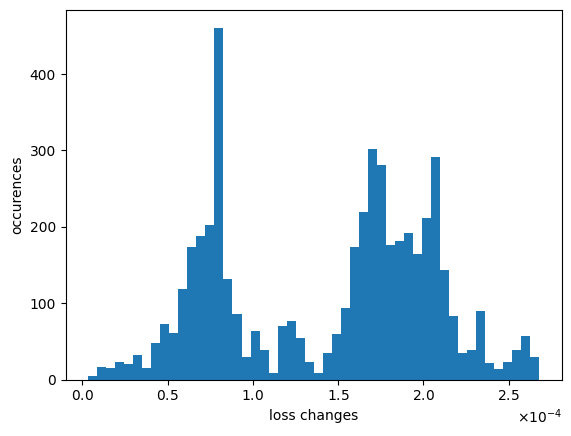

In [8]:
dead_ids = [ 1, 13, 15, 18, 25, 28, 33, 37, 39, 42, 47,  5,  9] # dead neurons we do not perturb

negative_perturb_df = perturbation_at_critical_point(mu, mu_p, width, random_seed, savefolder, dataset_generation_func = generate_5pt_dataset,\
    not_perturb_dead = True, dead_ids = dead_ids, Gaussian = False, perturb_times=5000, )

In [9]:
negative_perturb_df.head(20) # no negative loss change

,noise,loss_change
